# Imports

In [1]:
# imports

import os
import numpy as np
import random
import pandas as pd
import json
import datetime
import pickle
import matplotlib.pyplot as plt
from utils import *

In [2]:
# Global settings
FREQBINS = 25
SIGMA = 25

# From EDA
ROWS = 256
COLS = 256

# Control runtime
run_retrain = True
display_orig_filt_images = False

# Import and split data

In [3]:
# define file directory
directory = '../data/interim/PatternNet/images'

# create a list of all possible classes
all_classes = []
for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
        all_classes.append(item)
#print(all_classes)
        
# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']
        
# inspect the number of images per class
data = []
for class_name in classes:
    class_dir = os.path.join(directory, class_name)
    image_count = len(os.listdir(class_dir))
    data.append([class_name, image_count])
image_count_df = pd.DataFrame(data, columns=['Class', 'Total Image Count'])
print("The following classes were selected for evaluation:")
display(image_count_df)

# define the train, val, and test sets
train_files, val_files, test_files = generate_splits(classes, directory)

The following classes were selected for evaluation:


,Class,Total Image Count
0,beach,800
1,chaparral,800
2,dense_residential,800
3,forest,800
4,freeway,800
5,harbor,800
6,overpass,800
7,parking_space,800
8,river,800
9,swimming_pool,800


train/validation/test subsets were loaded from a pre-generated file
	Number of train files: 4799
	Number of val files: 1599
	Number of test files: 1601


# Utility functions

In [4]:
def fft_image(image):

    # Read the image
    # image = plt.imread(image)

    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image

    ydim, xdim = image_gray.shape
    win = np.outer(np.hanning(ydim),np.hanning(xdim))
    win = win/np.mean(win)
    
    # Compute the 2D FFT of the grayscale image
    fft_image = np.fft.fft2(image_gray*win)

    # Shift the zero frequency component to the center
    fft_image_shifted = np.fft.fftshift(fft_image)

    # Compute the magnitude spectrum (absolute value) of the shifted FFT
    magnitude_spectrum = np.abs(fft_image_shifted)
    
    return magnitude_spectrum


In [5]:
def apply_bandpass_filter(image, low_cutoff, high_cutoff):
    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image
   
    # Compute the 2D FFT of the image
    fft_image = np.fft.fft2(image_gray)
    fft_shifted = np.fft.fftshift(fft_image)
    
    # Create a mask for the bandpass filter
    rows, cols = image_gray.shape
    mask = np.zeros((rows, cols), np.uint8)
    center = (rows // 2, cols // 2)
    mask[int(center[0] - high_cutoff):int(center[0] + high_cutoff), int(center[1] - high_cutoff):int(center[1] + high_cutoff)] = 1
    mask[int(center[0] - low_cutoff):int(center[0] + low_cutoff), int(center[1] - low_cutoff):int(center[1] + low_cutoff)] = 0
    
    # Apply the mask to the frequency domain representation
    fft_shifted_filtered = fft_shifted * mask
    
    # Compute the inverse 2D FFT
    ifft_shifted_filtered = np.fft.ifftshift(fft_shifted_filtered)
    filtered_image = np.fft.ifft2(ifft_shifted_filtered)
    filtered_image = np.abs(filtered_image)
    
    return filtered_image.astype(np.uint8)


In [6]:
def create_filter(rows, cols, sigma):
    # Create Gaussian Filter: Low Pass Filter
    M,N = rows, cols
    H = np.zeros((M,N), dtype=np.float32)
    D0 = sigma
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = np.exp(-D**2/(2*D0*D0))

    return H

In [7]:
def apply_gaussian_filter(image, filt):
    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image

    # Compute the 2D FFT of the image
    fft_image = np.fft.fft2(image_gray)
    fft_shifted = np.fft.fftshift(fft_image)

    # Apply the mask to the frequency domain representation
    fft_shifted_filtered = fft_shifted * filt
    
    # Compute the inverse 2D FFT
    ifft_shifted_filtered = np.fft.ifftshift(fft_shifted_filtered)
    filtered_image = np.fft.ifft2(ifft_shifted_filtered)
    filtered_image = np.abs(filtered_image)

    return filtered_image.astype(np.uint8)


In [8]:
def create_dataframe(histogram_bins):
    fixed_column_names = ['class_name', 'class_id']
    empty_df = pd.DataFrame(columns=fixed_column_names)

    # Additional column names generated using list comprehension
    bin_names = [f'Bin_{i}' for i in range(1, histogram_bins + 1)] 

    # Add the additional columns to the empty DataFrame
    for column_name in bin_names:
        empty_df[column_name] = None  # Add the column with None values

    # Display the resulting DataFrame
    return (empty_df)


In [9]:
# define a function to run spectrum images in a directory (given a file subset)
# The function runs a FFT analysis on all training files 
def generate_freq_spectrum(files, directory, images_per_class=3):
    # create a dictionary to store class images
    class_images = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        # if class not in dictionary, initialize empty list
        if class_name not in class_images:
            class_images[class_name] = []
        # append image to class list
        class_images[class_name].append(img)

    # create a grid of images
    count = 0
    pd1 = create_dataframe(histogram_bins=FREQBINS)
    pd2 = create_dataframe(histogram_bins=FREQBINS)
    filt = create_filter(ROWS, COLS, SIGMA)
    
    num_classes = len(class_images)
    for i, (class_name, images) in enumerate(class_images.items()):
        # display random images in the subsequent columns
        random.shuffle(images)
        for j in range(images_per_class):
            magnitude_spectrum = fft_image(images[j])
            spec = np.log(1+magnitude_spectrum).ravel()
            
            hist, bins = np.histogram(spec, bins=FREQBINS) 
            hist1_df = pd.DataFrame([hist], columns=[f'Bin_{i}' for i in range(1, len(hist) + 1)], dtype=int)
            hist1_df['class_name'] = class_name
            hist1_df['class_id'] = i

            filtered_image = apply_gaussian_filter(images[j], filt)

            magnitude_spectrum = fft_image(filtered_image)
            spec = np.log(1+magnitude_spectrum).ravel()
            
            hist, bins = np.histogram(spec, bins=FREQBINS) 
            hist2_df = pd.DataFrame([hist], columns=[f'Bin_{i}' for i in range(1, len(hist) + 1)], dtype=int)
            hist2_df['class_name'] = class_name
            hist2_df['class_id'] = i
            
            count += 1
            
            pd1 = pd.concat([pd1, hist1_df], ignore_index=True)
            pd2 = pd.concat([pd2, hist2_df], ignore_index=True)
    
    return pd1, pd2

In [10]:
# define a function to show a grid of spectrum images in a directory (given a file subset)
def display_orig_filtered_image(files, directory, images_per_class=3, sigma=SIGMA):
    # create a dictionary to store class images
    class_images = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        # if class not in dictionary, initialize empty list
        if class_name not in class_images:
            class_images[class_name] = []
        # append image to class list
        class_images[class_name].append(img)

    # create a grid of images
    filt = create_filter(ROWS, COLS, sigma)
    
    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, (images_per_class + 1), figsize=(12, 3*num_classes))
    for i, (class_name, images) in enumerate(class_images.items()):
        #display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=16, ha='center', va='center')
        axes[i, 0].axis('off')

        # display random images in the subsequent columns
        random.shuffle(images)
        for j in range(images_per_class):
            magnitude_spectrum1 = fft_image(images[j])
            spec = np.log(1+magnitude_spectrum1).ravel()
            
            filtered_image = apply_gaussian_filter(images[j], filt)
            magnitude_spectrum2 = fft_image(filtered_image)
            spec = np.log(1+magnitude_spectrum2).ravel()
            
            #axes[i, j+1].imshow(images[j], cmap='gray')
            axes[i, j+1].imshow(filtered_image, cmap='gray')


    plt.tight_layout()
    plt.show()

    return

## main function to control execution

In [11]:
if run_retrain is True:
    start_time = datetime.datetime.now()
    unfilt_train_df, filt_train_df = generate_freq_spectrum(train_files, directory, images_per_class=450)
    end_time = datetime.datetime.now()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print("Time taken for training:", elapsed_time)

if display_orig_filt_images:
    display_orig_filtered_image(train_files, directory, images_per_class=1, sigma=SIGMA)

Time taken for training: 0:01:49.046062


Save both filtered and unfiltered dataframes for future analysis

In [12]:
csv_name = f'freq_spec_no_filt_bins_{FREQBINS}.csv'
directory = '../data/processed/'
file = directory + csv_name
unfilt_train_df.to_csv(directory+csv_name, index=False)

csv_name = f'freq_spec_lpf_{SIGMA}_bins_{FREQBINS}.csv'
directory = '../data/processed/'
file = directory + csv_name
filt_train_df.to_csv(directory+csv_name, index=False)

## Slice and Dice on training data
Peek-poke and summarise training data - filtered/unfiltered.

In [13]:
grouped_df = filt_train_df.loc[:,'class_id':'Bin_25'].groupby('class_id')
summary_df = grouped_df.agg(['median'])
print(summary_df)

          Bin_1  Bin_2  Bin_3  Bin_4   Bin_5    Bin_6    Bin_7    Bin_8  \
         median median median median  median   median   median   median   
class_id                                                                  
0          16.0   63.5  254.0  889.5  2947.0   8875.5  19825.0  19346.5   
1          16.0   66.0  253.0  941.0  3204.5   9736.0  20963.0  17187.0   
2          14.0   50.0  176.0  586.0  1850.5   5426.5  13351.0  20371.5   
3          15.0   60.0  232.0  841.5  2840.0   8710.5  19711.5  19501.5   
4          18.0   72.0  269.0  903.0  2887.0   8376.0  18771.5  21104.5   
5          14.0   58.0  216.0  756.5  2508.0   7665.5  17730.5  19131.5   
6          16.0   65.0  250.0  898.0  3031.0   9152.5  19950.0  18079.0   
7          16.0   64.0  247.0  885.0  2963.0   8996.0  19426.5  16793.0   
8          16.0   66.0  260.0  972.5  3359.5  10202.5  21726.5  18003.5   
9          16.0   58.0  216.0  750.5  2421.0   7269.0  16957.0  19132.0   

            Bin_9  Bin_1

In [14]:
#filt_train_df.loc[0:4, 'class_name': 'Bin_10']

In [15]:
#filt_train_df.loc[0:2, 'Bin_1': 'Bin_20'].plot(kind='bar', legend=False)
#plt.xlabel(filt_train_df.columns[0])
#plt.ylabel('Frequency')
#plt.title('Histogram from DataFrame with Bins as Columns')
#plt.show()


In [16]:
#filt_train_df.loc[:,'class_id':'Bin_14']

## Run prediction models on test data
Try Random forest and KNN on training data

In [26]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

shuffled_df = filt_train_df.sample(frac=1).reset_index(drop=True)

X = shuffled_df.loc[:, 'Bin_1': 'Bin_25']
y = shuffled_df['class_name']

# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100, max_depth=10)  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation
print("Accuracy of RF model:", metrics.accuracy_score(y_test, y_pred))

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)# Fit the classifier to the data
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy of KNN model: ', knn.score(X_test, y_test))

Accuracy of RF model: 0.8659259259259259
Accuracy of KNN model:  0.7540740740740741


## PCA
See which features (bins) are of importance 

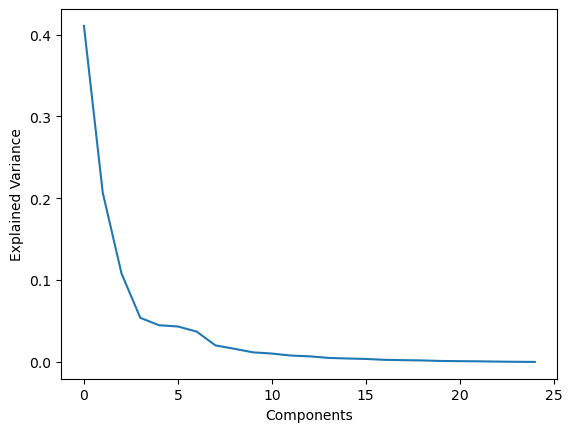

             PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
Bin_1   0.185853  0.229225 -0.101941  0.118720  0.246443  0.024064  0.148980   
Bin_2   0.223116  0.230910 -0.088582  0.101260  0.186954  0.025984  0.107735   
Bin_3   0.244600  0.232747 -0.079939  0.068139  0.140973  0.026798  0.085814   
Bin_4   0.255911  0.230956 -0.067533  0.034740  0.084104  0.038033  0.067053   
Bin_5   0.262238  0.225158 -0.061746 -0.001662  0.024460  0.043617  0.045604   
Bin_6   0.267919  0.210925 -0.042281 -0.045641 -0.064752  0.042678 -0.011586   
Bin_7   0.264082  0.129950  0.040799 -0.116780 -0.279650  0.002094 -0.211827   
Bin_8  -0.183008 -0.307056  0.157093  0.058903 -0.052047 -0.090711 -0.167142   
Bin_9  -0.207844 -0.218230 -0.035810  0.131457  0.357758  0.055802  0.329722   
Bin_10 -0.187126 -0.067953 -0.223532  0.009619  0.270345  0.319505  0.441039   
Bin_11 -0.188839  0.085510 -0.304004 -0.141389 -0.180467  0.391108 -0.006525   
Bin_12 -0.199412  0.134533 -0.305954 -0.

In [27]:
from sklearn.decomposition import PCA

df = filt_train_df.loc[:, 'Bin_1': 'Bin_25']

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()


# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)




In [19]:
dictbin = {}
for i in loadings.columns:
    k = loadings.sort_values(by=[i])
    bincount = 0
    for bins in k.index:
        bincount += 1
        if bincount == 10:
            break
        if bins in dictbin:
            dictbin[bins] += 1
        else:
            dictbin[bins] = 0

sorted_by_values= sorted(dictbin.items(), key=lambda x: x[1], reverse=True)

# Print the sorted dictionary
for key, value in sorted_by_values:
    print(key, value)

Bin_11 14
Bin_20 13
Bin_14 11
Bin_13 11
Bin_12 11
Bin_8 11
Bin_18 10
Bin_7 10
Bin_15 9
Bin_16 9
Bin_2 9
Bin_17 8
Bin_9 8
Bin_25 8
Bin_10 7
Bin_3 7
Bin_19 6
Bin_23 6
Bin_6 6
Bin_24 5
Bin_21 5
Bin_4 5
Bin_1 4
Bin_5 4
Bin_22 3


In [20]:
# Use this codeblock to read from pre-trained data
if not run_retrain:
    csv_name = f'freq_spec_lpf_{SIGMA}_bins_{FREQBINS}.csv'
    directory = '../data/processed/'
    file = directory + csv_name
    filt_train_df = pd.read_csv(directory+csv_name)
    
    csv_name = f'freq_spec_no_filt_bins_{FREQBINS}.csv'
    directory = '../data/processed/'
    file = directory + csv_name
    unfilt_train_df = pd.read_csv(directory+csv_name)